# Check on the files exported by Equivital Qiosk

Plot and review measurements from equivital sensors as output by the Equivital Qiosk application, second installation.

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import heartpy as hp

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
tic = time.time()
print(time.time()-tic)

0.0


## Definitions for data extraction

In [3]:
%load_ext autoreload
%autoreload 1
%aimport qex

In [12]:
%reload_ext autoreload

In [23]:
# running on mac
seperator = '/'
seperator

'/'

In [4]:
pwd

'C:\\Users\\fourMs lab\\Documents\\Equivital_data_reviewing-main'

In [4]:
seperator = str('\\')
seperator

'\\'

# Scan for DATA files in Qiosk exported files
Check the usual spot that QIOSK deposits files for data files detailing recordings

In [21]:
# location of the files when exported by QIOSK
path = "C:\\Users\\Public\\Documents\\Equivital\\Equivital Manager Wizard\\"#Extracted SEM Data\\" #"../Equivital/Equivital Manager Wizard/Extracted SEM Data/"
#os.listdir(path)

In [ ]:
path = '/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/'
a = qex.qiosk_recordings(path,'Present',seperater)
a

In [29]:
df_datafiles = qex.qiosk_recordings(path,'Present',seperator)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,Pilot 58,5022240,230130,0,DATA-Pilot 58-5022240-23013000.CSV,csv,219,2023-01-30 14:55:15+00:00,2023-01-30 14:55:15+00:00,...,[Pilot 58],5022240.0,Pilot 58,NaN,130.0,67.0,1.0,1.0,Stationary,Prone
1,DATA,Pilot 57,5022002,230130,0,DATA-Pilot 57-5022002-23013000.CSV,csv,221,2023-01-30 14:55:15+00:00,2023-01-30 14:55:15+00:00,...,[Pilot 57],5022002.0,Pilot 57,NaN,56.0,10.0,1.0,1.0,Stationary,Inverted
2,DATA,Pilot 42,5022143,230131,0,DATA-Pilot 42-5022143-23013100.CSV,csv,219,2023-01-31 10:22:56+00:00,2023-01-31 10:22:56+00:00,...,[Pilot 42],5022143.0,Pilot 42,NaN,104.0,95.0,1.0,1.0,Stationary,Prone
3,DATA,Pilot_1,3420755,230206,0,DATA-Pilot_1-3420755-23020600.CSV,csv,188,2023-02-06 10:35:11+00:00,2023-02-06 10:35:11+00:00,...,[Pilot_1],3420755.0,Pilot_1,NaN,6.0,100.0,1.0,1.0,MovingSlowly,Prone
4,DATA,Pilot_5,5022126,230207,0,DATA-Pilot_5-5022126-23020700.CSV,csv,185,2023-02-07 10:09:13+00:00,2023-02-07 10:09:13+00:00,...,[Pilot_5],5022126.0,Pilot_5,NaN,32.0,81.0,1.0,1.0,Stationary,Side
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,DATA,VN202,5022051,230214,1,DATA-VN202-5022051-23021401.CSV,csv,545,2023-02-14 13:46:06+00:00,2023-02-14 13:47:06+00:00,...,[VN202],5022051.0,VN202,NaN,92.0,100.0,1.0,1.0,Stationary,Side
75,DATA,VN207,5022073,230214,2,DATA-VN207-5022073-23021402.CSV,csv,944,2023-02-14 13:46:08+00:00,2023-02-14 13:48:23+00:00,...,[VN207],5022073.0,VN207,NaN,122.0,71.0,1.0,1.0,Stationary,Side
76,DATA,VN203,5022057,230214,1,DATA-VN203-5022057-23021401.CSV,csv,546,2023-02-14 13:46:10+00:00,2023-02-14 13:47:10+00:00,...,[VN203],5022057.0,VN203,NaN,120.0,100.0,1.0,1.0,Stationary,Side
77,DATA,Bluetooth04,5022297,230214,1,DATA-Bluetooth04-5022297-23021401.CSV,csv,1914,2023-02-14 15:11:53+00:00,2023-02-14 15:16:38+00:00,...,[Bluetooth04],5022297.0,Bluetooth04,NaN,64.0,38.0,0.0,1.0,MovingSlowly,Upright


In [28]:
proj_name = 'test'
df_datafiles = qex.qiosk_recordings(path,proj_name,seperator)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,FullLoc,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,Bluetooth01,5022281,230213,0,DATA-Bluetooth01-5022281-23021300.CSV,csv,134,2020-02-02 02:02:00+00:00,C:\Users\Public\Documents\Equivital\Equivital ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DATA,Pilot_3,3420427,230130,0,DATA-Pilot_3-3420427-23013000.CSV,csv,109,2020-02-02 02:02:00+00:00,C:\Users\Public\Documents\Equivital\Equivital ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DATA,Pilot_3,3420427,230208,0,DATA-Pilot_3-3420427-23020800.CSV,csv,109,2020-02-02 02:02:00+00:00,C:\Users\Public\Documents\Equivital\Equivital ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DATA,Pilot_3,3420427,230210,0,DATA-Pilot_3-3420427-23021000.CSV,csv,134,2020-02-02 02:02:00+00:00,C:\Users\Public\Documents\Equivital\Equivital ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DATA,Pilot_30,5022141,230130,0,DATA-Pilot_30-5022141-23013000.CSV,csv,134,2020-02-02 02:02:00+00:00,C:\Users\Public\Documents\Equivital\Equivital ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,DATA,VN205,5022060,230214,1,DATA-VN205-5022060-23021401.CSV,csv,542,2023-02-14 13:46:06+00:00,C:\Users\Public\Documents\Equivital\Equivital ...,...,[VN205],5022060.0,VN205,NaN,108.0,100.0,1.0,1.0,Stationary,Side
297,DATA,VN207,5022073,230214,2,DATA-VN207-5022073-23021402.CSV,csv,944,2023-02-14 13:46:08+00:00,C:\Users\Public\Documents\Equivital\Equivital ...,...,[VN207],5022073.0,VN207,NaN,122.0,71.0,1.0,1.0,Stationary,Side
298,DATA,VN203,5022057,230214,1,DATA-VN203-5022057-23021401.CSV,csv,546,2023-02-14 13:46:10+00:00,C:\Users\Public\Documents\Equivital\Equivital ...,...,[VN203],5022057.0,VN203,NaN,120.0,100.0,1.0,1.0,Stationary,Side
299,DATA,Bluetooth04,5022297,230214,1,DATA-Bluetooth04-5022297-23021401.CSV,csv,1914,2023-02-14 15:11:53+00:00,C:\Users\Public\Documents\Equivital\Equivital ...,...,[Bluetooth04],5022297.0,Bluetooth04,NaN,64.0,38.0,0.0,1.0,MovingSlowly,Upright


In [31]:
# key categories to structure of Qiosk output DATA files
print('Number of DATA files: '+ str(len(df_datafiles)))
print(df_datafiles['ID'].unique())
print(df_datafiles['DevName'].unique())
print(df_datafiles['Date'].unique())

Number of DATA files: 79
[5022240 5022002 5022143 3420755 5022126 3420415 5022207 5022198 5022100
 5022073 5022285 5022281 5022297 5022292 5022050 5022179 5022138 5022139
 5022184 5022193 5022101 5022104 5022238 5022051 3420426 5022057 5022141
 5022142 5022117 5022241 5022110 5022155 3420427 5023926 5022156 5022060
 5022149 5022161 5022058 5022077 5022154 3420456 5022173 5022245 5022163
 5022164 5022062 5022127 5022202 5022203 5022076 5022204 5022098 5022131
 5022151 5022166 5022152 5022006]
['Pilot 58' 'Pilot 57' 'Pilot 42' 'Pilot_1' 'Pilot_5' 'Bluetooth_Tester_1'
 'BR608' 'BR604' 'VA301' 'VN207' 'Bluetooth02' 'Bluetooth01' 'Bluetooth04'
 'Bluetooth03' 'VN201' 'BR601' 'VN101' 'LS401' 'LS402' 'BR602' 'BR603'
 'VA302' 'VA303' 'PC701' 'PC702' 'VN202' 'VN102' 'VN203' 'LS403' 'LS404'
 'VA305' 'PC703' 'VA304' 'WW501' 'VN105' 'VN103' 'LS406' 'WW502' 'VN205'
 'LS407' 'LS405' 'WW503' 'VN204' 'VN209' 'LS410' 'VA306' 'VN104' 'WW507'
 'PC705' 'WW504' 'WW505' 'VN206' 'VA307' 'BR605' 'BR606' 'VN208

### OR scan files from a project folder outside of the automatic qiosk export folders

In [5]:
projectName = '230214_Equivital' # this needs to match the project folder name
path = "D:\\"+projectName+"\\"#Extracted SEM Data\\" #"../Equivital/Equivital Manager Wizard/Extracted SEM Data/"

df_datafiles = qex.qiosk_recordings(path,projectName,seperator)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,VA304,5022110,230214,0,DATA-VA304-5022110-23021400-cut.csv,csv,80491,2023-02-14 08:55:02+00:00,2023-02-14 12:59:47+00:00,...,[VA304],5022110.0,VA304,NaN,63,98.0,0.0,0.0,Stationary,Upright
1,DATA,BR604,5022198,230214,101,DATA-BR604-5022198-23021400_0-cut.csv,csv,80215,2023-02-14 08:55:04+00:00,2023-02-14 12:59:49+00:00,...,[BR604],5022198.0,BR604,NaN,65,98.0,0.0,0.0,Stationary,Upright
2,DATA,VN205,5022060,230214,0,DATA-VN205-5022060-23021400-cut.csv,csv,80246,2023-02-14 08:55:04+00:00,2023-02-14 12:59:49+00:00,...,[VN205],5022060.0,VN205,NaN,63,99.0,0.0,0.0,Stationary,Upright
3,DATA,PC702,5022240,230214,0,DATA-PC702-5022240-23021400-cut.csv,csv,80308,2023-02-14 08:55:04+00:00,2023-02-14 12:59:49+00:00,...,[PC702],5022240.0,PC702,NaN,70,98.0,0.0,0.0,Stationary,Upright
4,DATA,VN202,5022051,230214,0,DATA-VN202-5022051-23021400-cut.csv,csv,80336,2023-02-14 08:55:04+00:00,2023-02-14 12:59:51+00:00,...,[VN202],5022051.0,VN202,NaN,84,99.0,0.0,0.0,Stationary,Upright
5,DATA,PC703,5022241,230214,0,DATA-PC703-5022241-23021400-cut.csv,csv,80996,2023-02-14 08:55:05+00:00,2023-02-14 12:59:50+00:00,...,[PC703],5022241.0,PC703,NaN,74,100.0,0.0,0.0,Stationary,Upright
6,DATA,LS401,5022138,230214,0,DATA-LS401-5022138-23021400-cut.csv,csv,80302,2023-02-14 08:55:05+00:00,2023-02-14 12:59:50+00:00,...,[LS401],5022138.0,LS401,NaN,70,99.0,0.0,0.0,Stationary,Upright
7,DATA,PC701,5022238,230214,0,DATA-PC701-5022238-23021400-cut.csv,csv,80391,2023-02-14 08:55:05+00:00,2023-02-14 12:59:50+00:00,...,[PC701],5022238.0,PC701,NaN,80,98.0,0.0,0.0,Stationary,Upright
8,DATA,WW502,5022156,230214,0,DATA-WW502-5022156-23021400-cut.csv,csv,80378,2023-02-14 08:55:06+00:00,2023-02-14 12:59:51+00:00,...,[WW502],5022156.0,WW502,NaN,70,98.0,0.0,0.0,Stationary,Upright
9,DATA,LS403,5022141,230214,0,DATA-LS403-5022141-23021400-cut.csv,csv,80401,2023-02-14 08:55:07+00:00,2023-02-14 12:59:52+00:00,...,[LS403],5022141.0,LS403,NaN,88,98.0,0.0,0.0,Stationary,Upright


In [6]:
# key categories to structure of Qiosk output DATA files
print('Number of DATA files: '+ str(len(df_datafiles)))
print(df_datafiles['ID'].unique())
print(df_datafiles['DevName'].unique())
print(df_datafiles['Date'].unique())

Number of DATA files: 41
[5022110 5022198 5022060 5022240 5022051 5022241 5022138 5022238 5022156
 5022141 5022142 5022050 5022117 5022104 5022193 5022100 5022057 3420415
 5023926 5022179 5022101 3420426 5022184 5022155 3420427 5022139 5022149
 5022143 5022161 5022058 5022077 5022154 5022126 3420456 5022245 5022163
 5022164 5022062 5022073 5022127 3420755]
['VA304' 'BR604' 'VN205' 'PC702' 'VN202' 'PC703' 'LS401' 'PC701' 'WW502'
 'LS403' 'LS404' 'VN201' 'VA305' 'VA303' 'BR603' 'VA301' 'VN203' 'VN101'
 'LS406' 'BR601' 'VA302' 'VN102' 'BR602' 'WW501' 'VN103' 'LS402' 'LS407'
 'LS405' 'WW503' 'VN204' 'VN209' 'LS410' 'VA306' 'VN104' 'PC705' 'WW504'
 'WW505' 'VN206' 'VN207' 'VA307' 'VN105']
[230214]


# Review recordings from a specific device and recording time
First preview files from a specific device (or other feild), then find the other signal files that match that Data files

In [14]:
# DATA files from one device, by the more reliable device ID numbr
devName = 'PC705' #'LS405'
s_files=df_datafiles.loc[df_datafiles['DevName'] == devName,:] 
#s_files=df_datafiles.loc[df_datafiles['Date'] == 230127,:]

# t = pd.to_datetime('2023-01-27 10:30:00.00+0000')# V['DateTime'].iloc[int(len(V)/2)]
# s_files=s_files.loc[s_files['RecStart']< t,:] 
s_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
34,DATA,PC705,5022245,230214,0,DATA-PC705-5022245-23021400-cut.csv,csv,73503,2023-02-14 09:11:33+00:00,2023-02-14 12:59:48+00:00,...,[PC705],5022245.0,PC705,NaN,30,100.0,0.0,1.0,Stationary,Prone


In [15]:
fileN = 0
eq_file_loc = s_files.iloc[0,14]
print(eq_file_loc)

D:\230214_Equivital\CSV\DATA-PC705-5022245-23021400-cut.csv


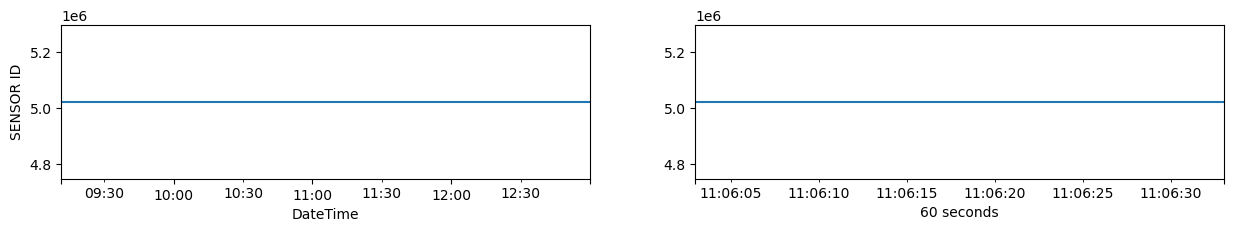

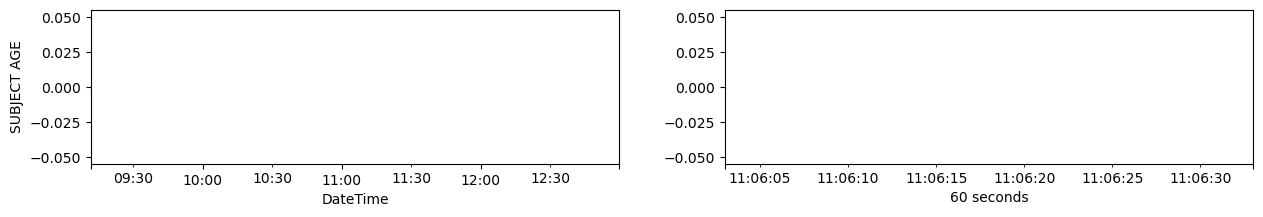

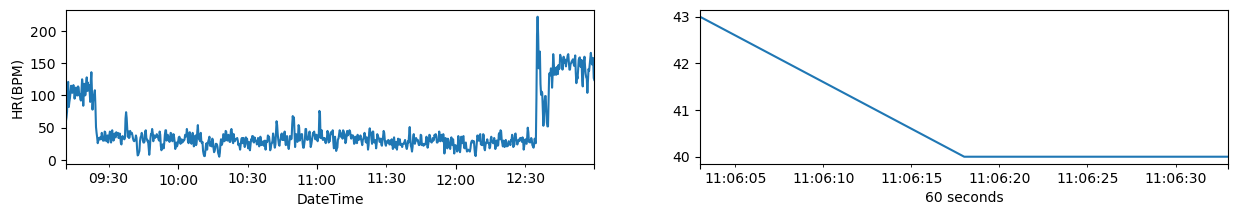

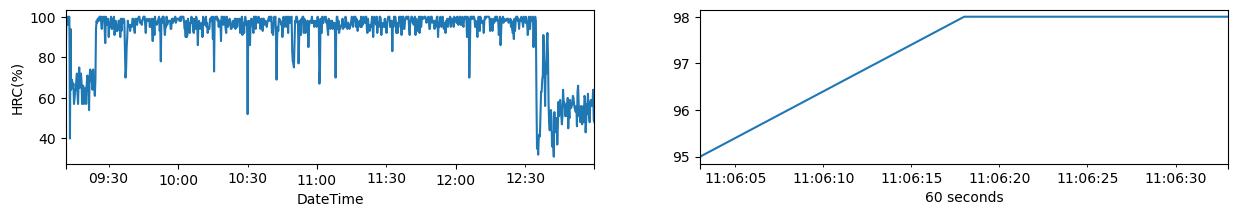

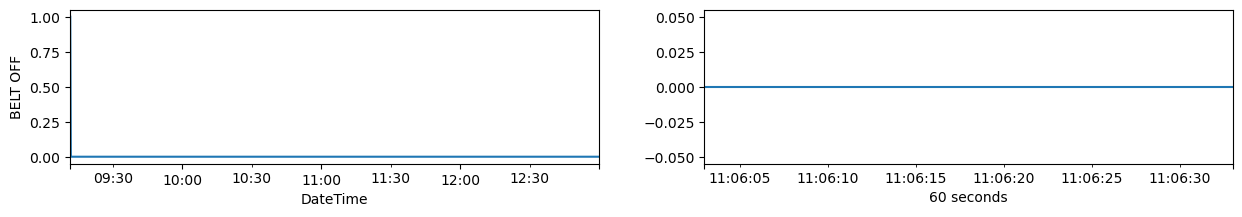

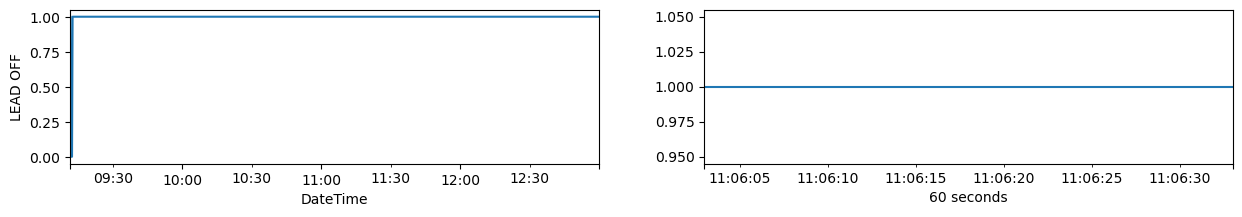

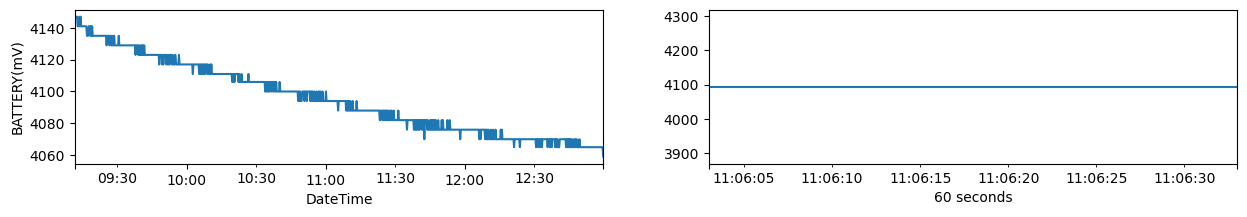

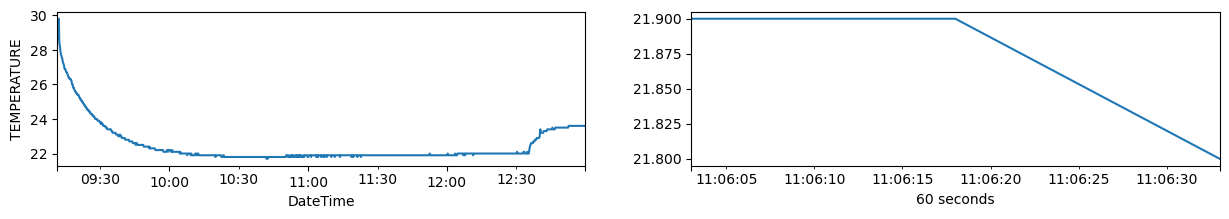

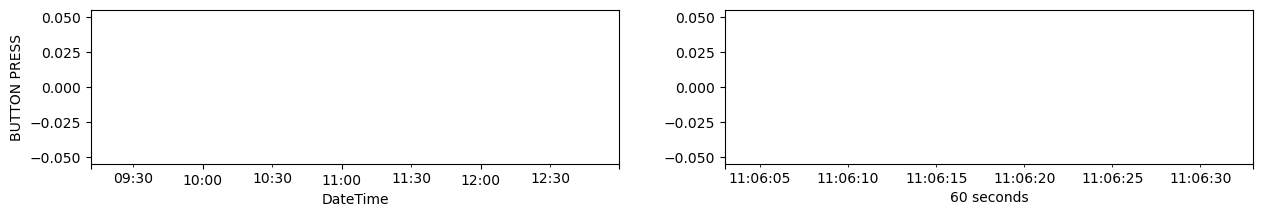

,DateTime,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION,BATTERY(mV),TEMPERATURE,BUTTON PRESS
0,2023-02-14 09:11:33+00:00,5022245,PC705,NaN,60,85,1,1,MovingFast,Unknown,4147,28.6,NaN
1,2023-02-14 09:11:48+00:00,5022245,PC705,NaN,66,100,0,0,MovingSlowly,Upright,4147,28.6,NaN
2,2023-02-14 09:12:03+00:00,5022245,PC705,NaN,75,100,0,0,MovingSlowly,Upright,4147,29.4,NaN
3,2023-02-14 09:12:18+00:00,5022245,PC705,NaN,118,97,0,0,Stationary,Prone,4147,29.8,NaN
4,2023-02-14 09:12:33+00:00,5022245,PC705,NaN,121,96,0,1,Stationary,Prone,4147,28.4,NaN


In [16]:
# Plot a quick view of the DATA file numeric fields
V = pd.read_csv(eq_file_loc,skipinitialspace=True)
qex.test_plot_signals(V)
V.iloc[:5]

Now grab all the files from that recording and presente a test plot of each, full and middle minute


In [10]:
matched = qex.matched_files(eq_file_loc,path,seperator) # outputs locations of csv 
matched

['D:\\230214_Equivital\\CSV\\DATA-LS405-5022143-23021400-cut.csv',
 'D:\\230214_Equivital\\CSV\\ECG-LS405-5022143-23021400-cut.csv',
 'D:\\230214_Equivital\\CSV\\FASTACC-LS405-5022143-23021400-cut.csv',
 'D:\\230214_Equivital\\CSV\\RESPACC-LS405-5022143-23021400-cut.csv',
 'D:\\230214_Equivital\\CSV\\RR-LS405-5022143-23021400-cut.csv',
 '']

In [11]:
pwd

'C:\\Users\\fourMs lab\\Documents\\Equivital_data_reviewing-main'

Index(['DateTime', 'SENSOR ID', 'SUBJECT ID', 'SUBJECT AGE', 'HR(BPM)',
       'HRC(%)', 'BELT OFF', 'LEAD OFF', 'MOTION', 'BODY POSITION',
       'BATTERY(mV)', 'TEMPERATURE', 'BUTTON PRESS'],
      dtype='object')


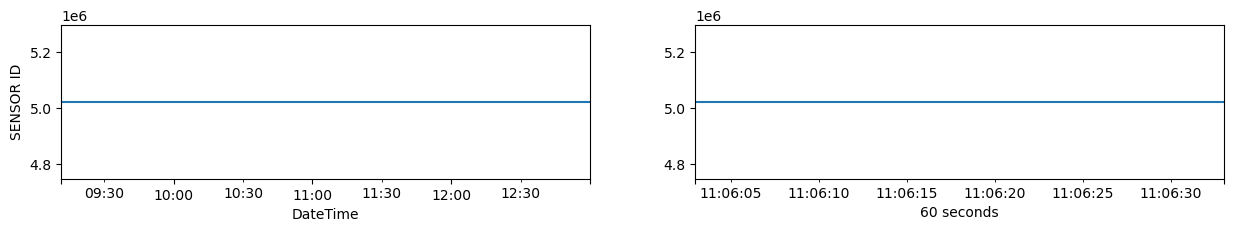

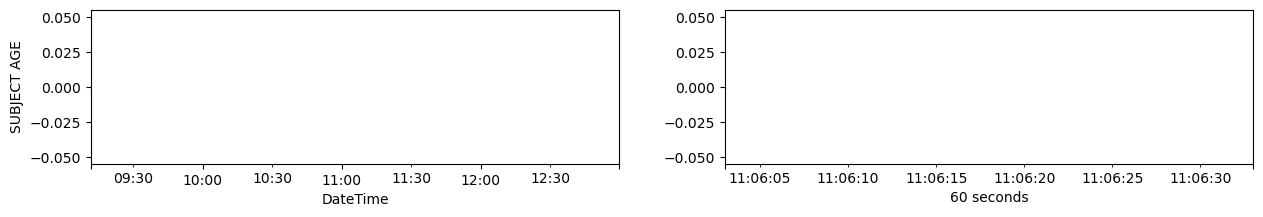

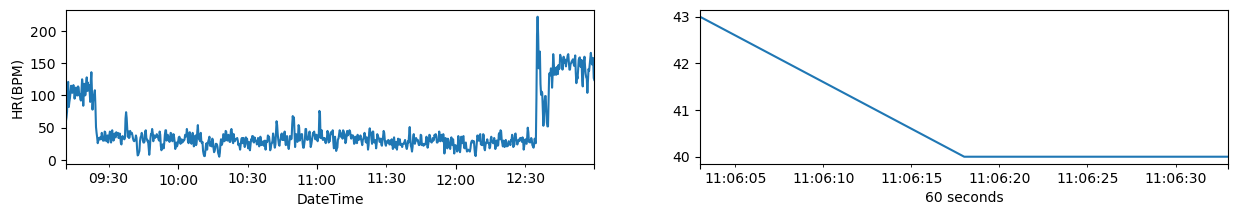

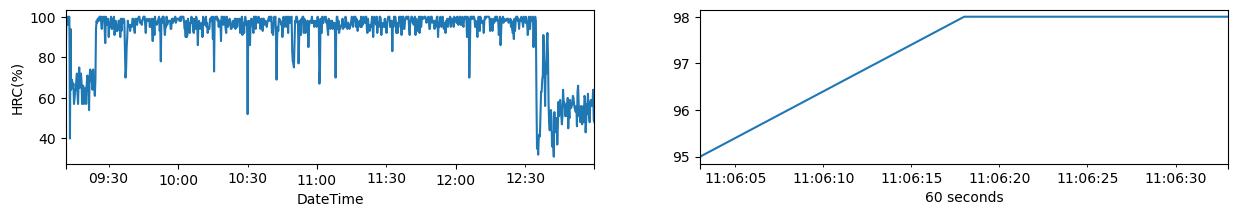

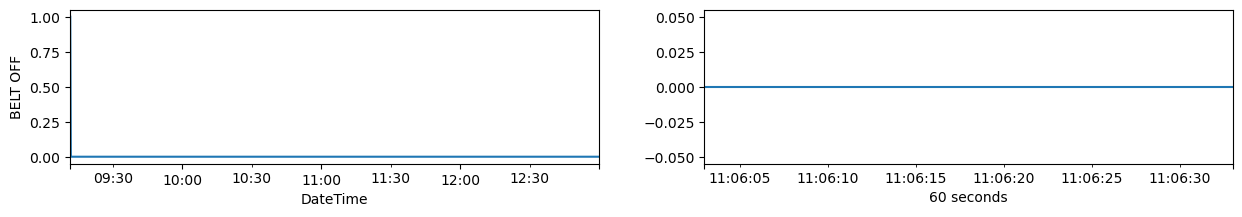

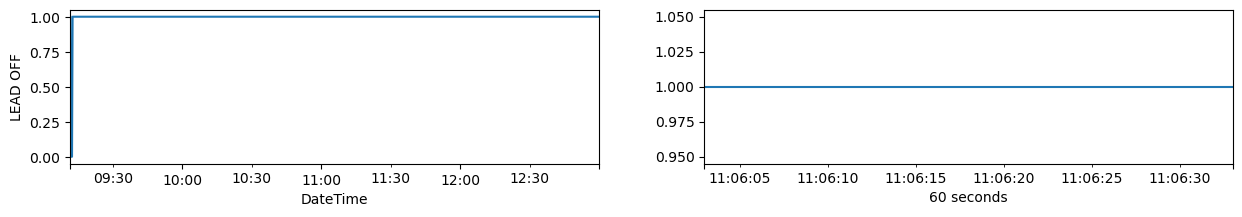

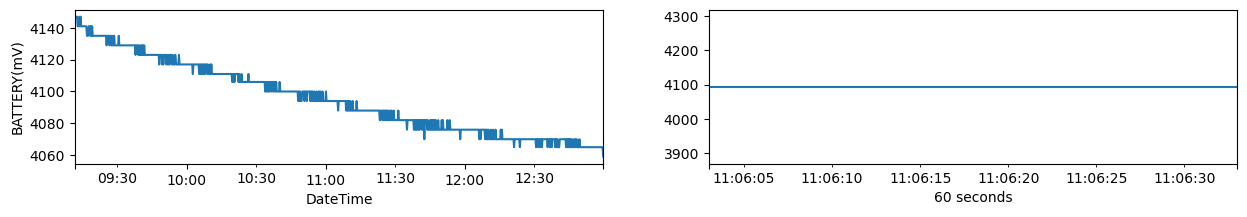

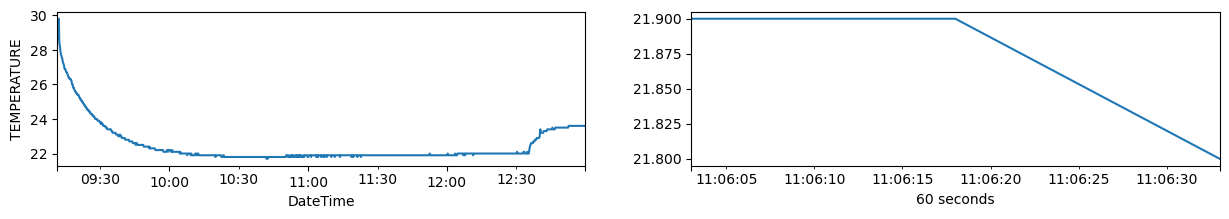

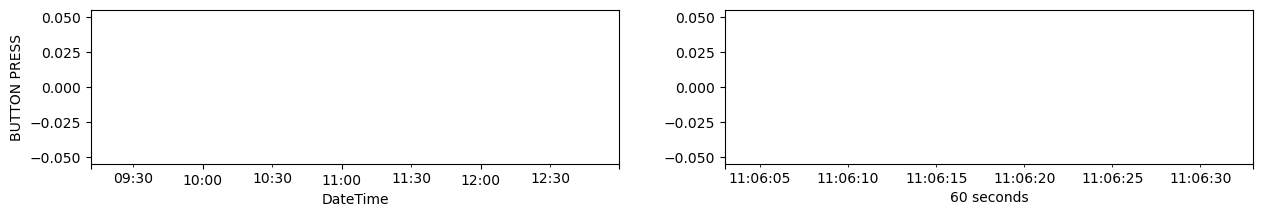

1.0845887660980225
Index(['DateTime', 'Lead 1', 'Lead 2'], dtype='object')


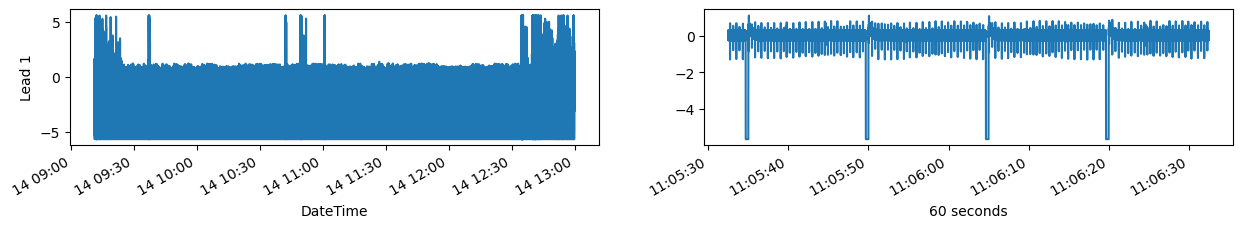

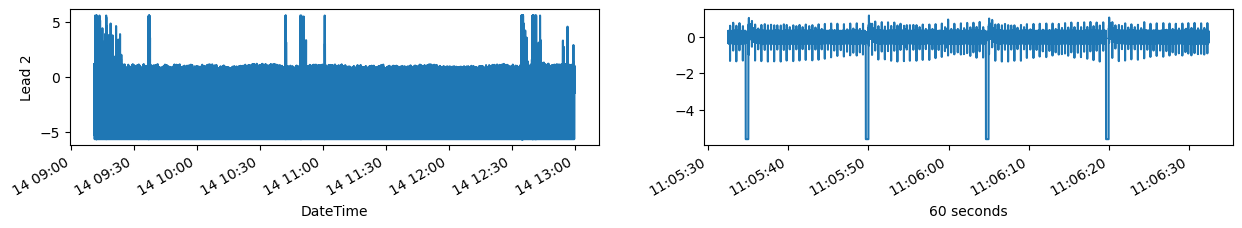

67.5090606212616
Index(['DateTime', 'Vert Accelerometer', 'Lat Accelerometer',
       'Long Accelerometer'],
      dtype='object')


In [ ]:
tic = time.time()

matched = qex.matched_files(eq_file_loc,path,seperator) # outputs locations of csv 
for eq_file_loc in matched:
    if eq_file_loc.lower().endswith('.csv'):
        V = pd.read_csv(eq_file_loc,skipinitialspace=True)
        print(V.columns)
        qex.test_plot_signals(V)

        print(time.time()-tic)

Index(['DateTime', 'SENSOR ID', 'SUBJECT ID', 'SUBJECT AGE', 'HR(BPM)',
       'HRC(%)', 'BELT OFF', 'LEAD OFF', 'MOTION', 'BODY POSITION',
       'BATTERY(mV)', 'TEMPERATURE', 'BUTTON PRESS'],
      dtype='object')


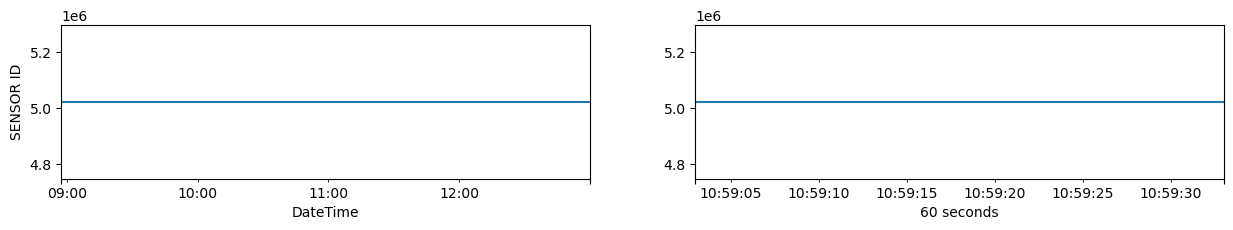

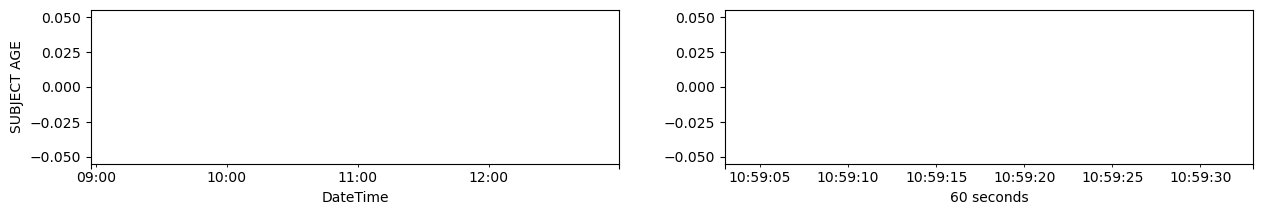

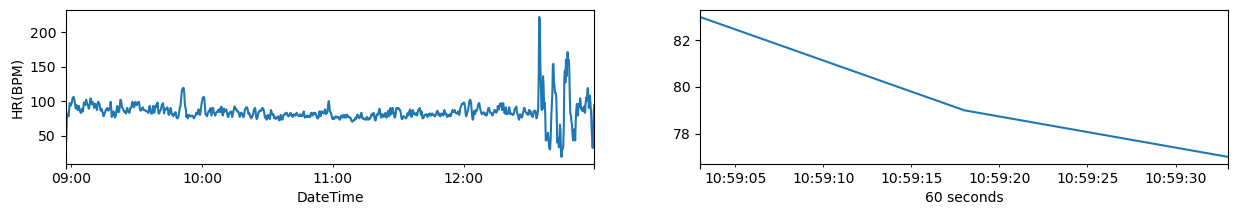

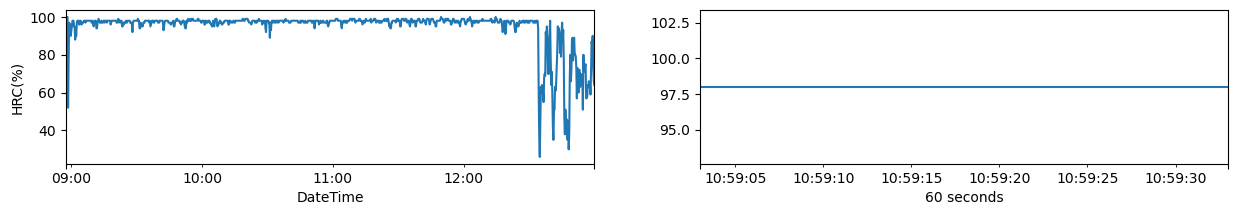

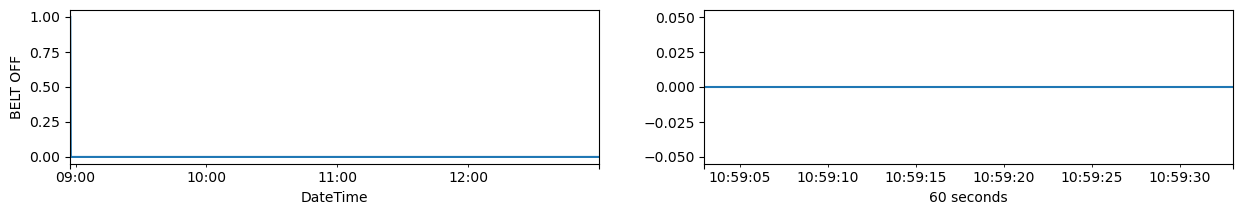

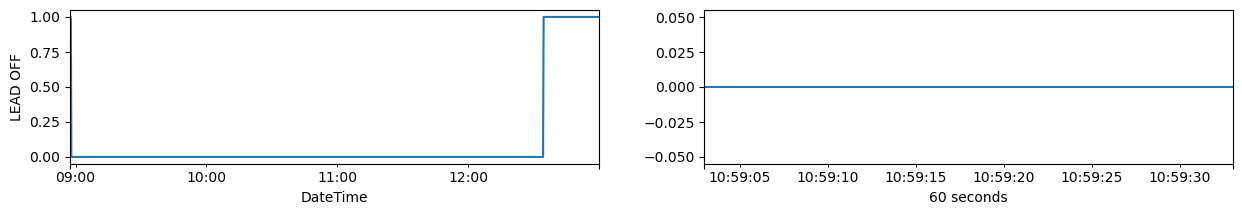

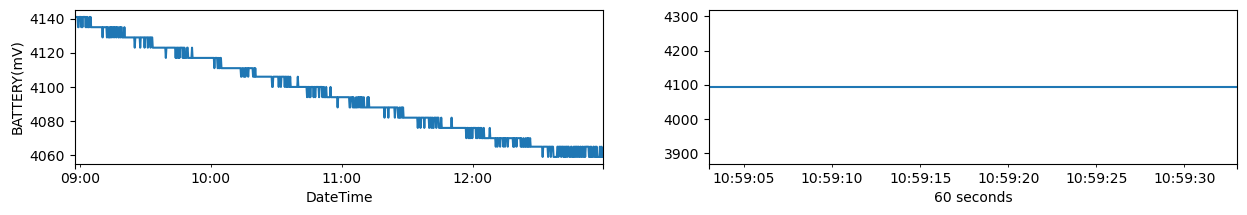

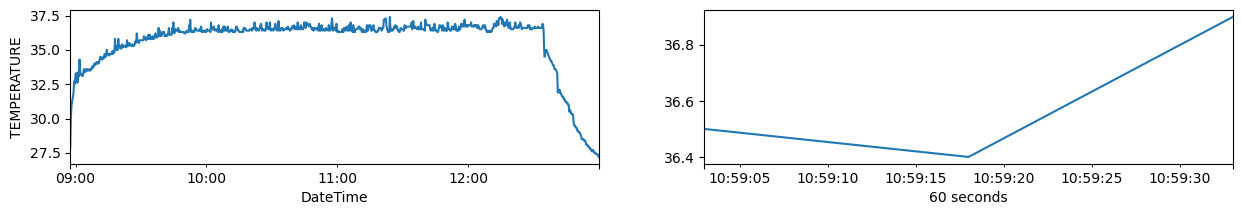

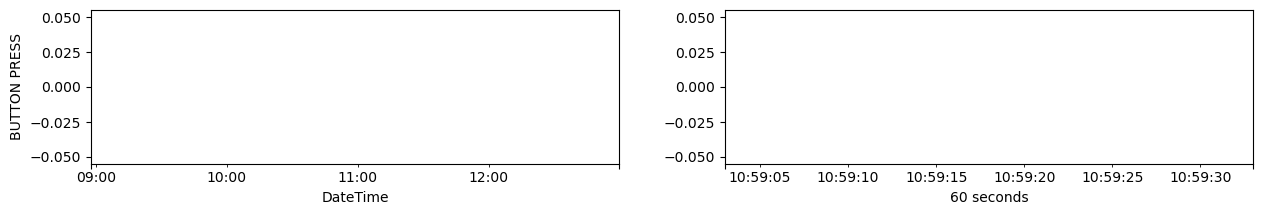

1.0964093208312988
Index(['DateTime', 'Lead 1', 'Lead 2'], dtype='object')


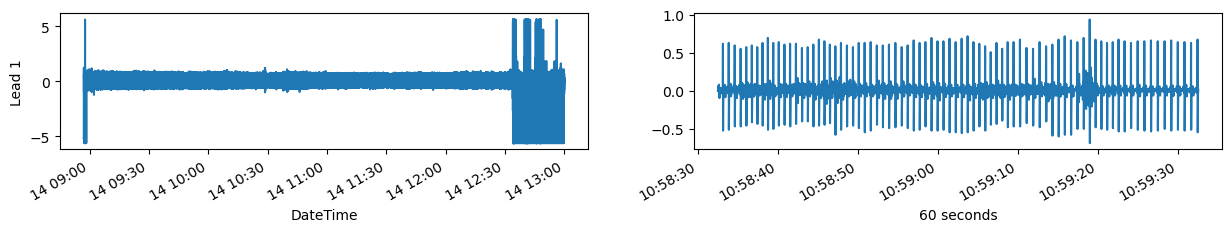

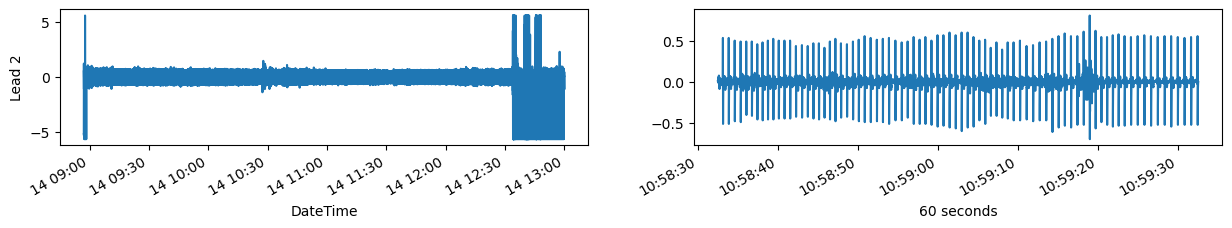

72.47602796554565
Index(['DateTime', 'Vert Accelerometer', 'Lat Accelerometer',
       'Long Accelerometer'],
      dtype='object')


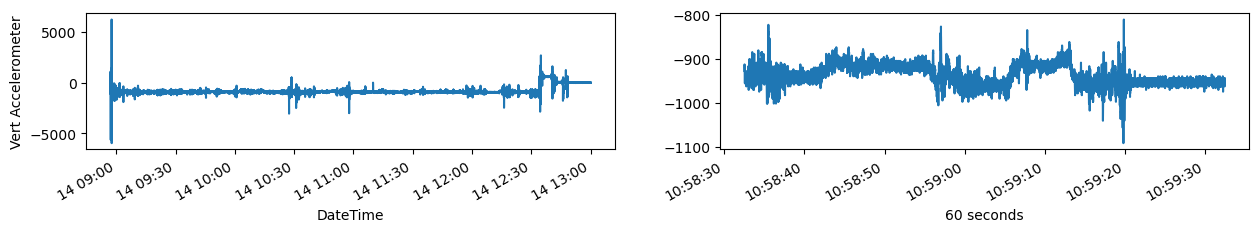

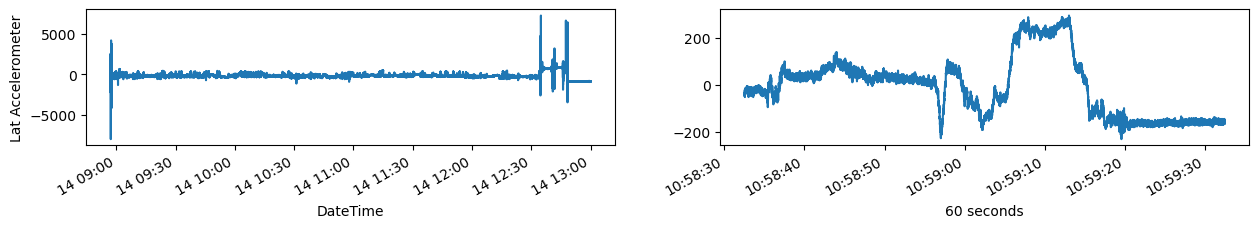

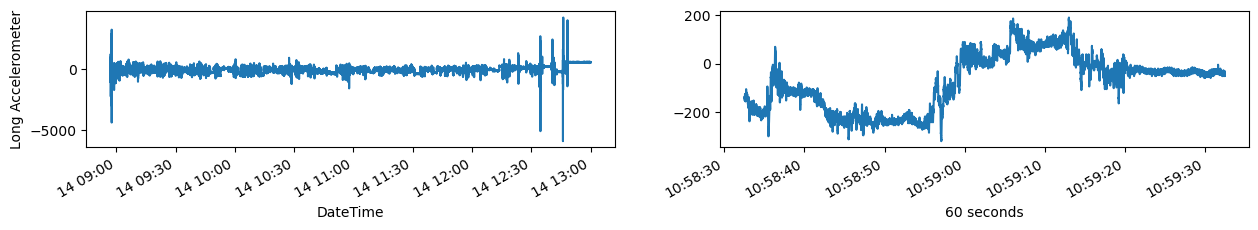

172.87929677963257
Index(['DateTime', 'Breathing'], dtype='object')


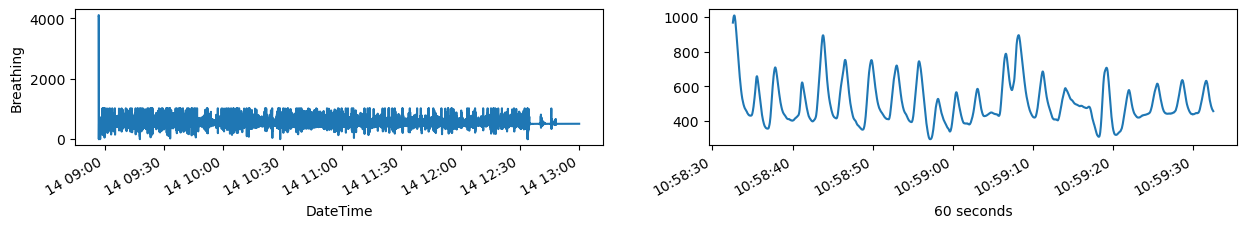

176.72257161140442
Index(['DateTime', 'Interbeat Interval (MS)'], dtype='object')


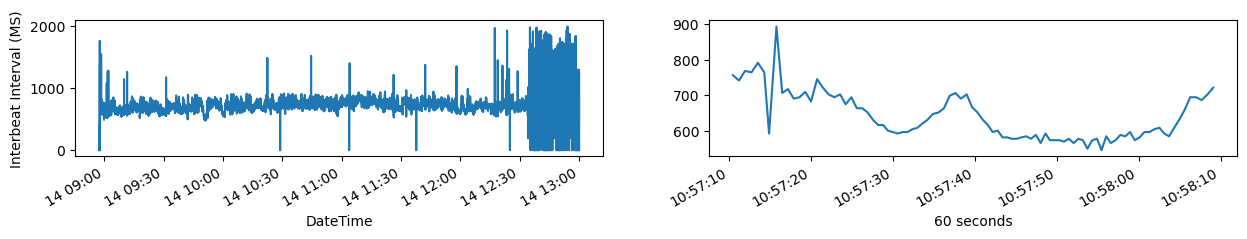

177.1832571029663


FileNotFoundError: [Errno 2] No such file or directory: ''

In [12]:
tic = time.time()

matched = qex.matched_files(eq_file_loc,path,seperator) # outputs locations of csv 
for eq_file_loc in matched:
    if eq_file_loc.lower().endswith('.csv'):
        V = pd.read_csv(eq_file_loc,skipinitialspace=True)
        print(V.columns)
        qex.test_plot_signals(V)

        print(time.time()-tic)

In [13]:
eq_file_loc

''

# Plot all signals recorded at specific time

In [54]:
# the times at which you want to check the recording
# note: make sure you set the times to within the recording interval for that file!!
t1 = pd.to_datetime('2023-02-14 9:05:00.00+0100')# V['DateTime'].iloc[int(len(V)/2)]
t2 = pd.to_datetime('2023-02-14 14:00:00.00+0100')
#t2 = t1+pd.to_timedelta(240,'s')
[t1,t2]

[Timestamp('2023-02-14 10:00:00+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2023-02-14 14:00:00+0100', tz='pytz.FixedOffset(60)')]

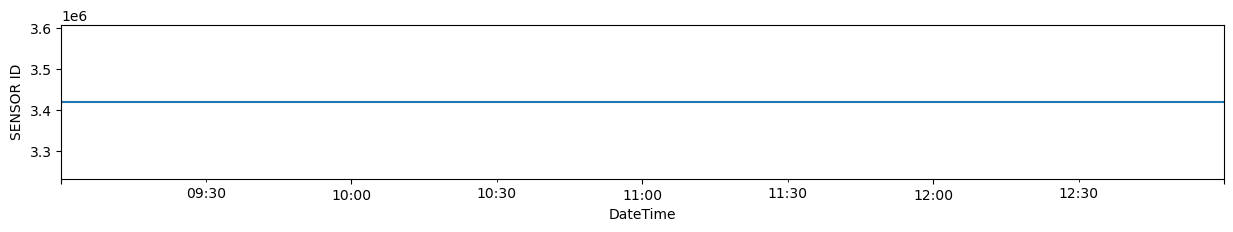

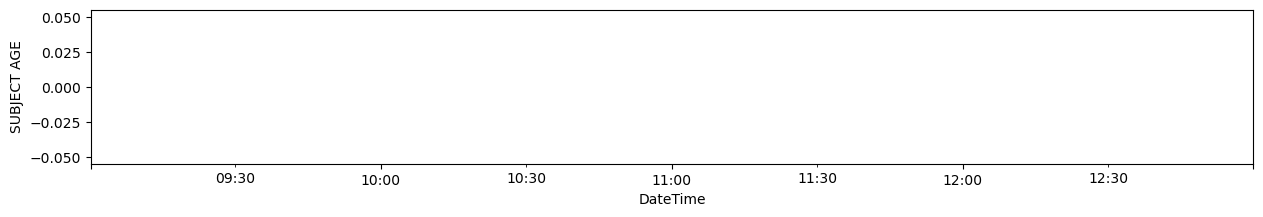

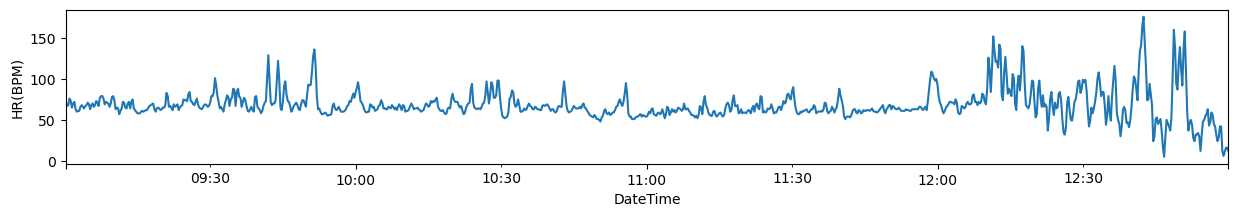

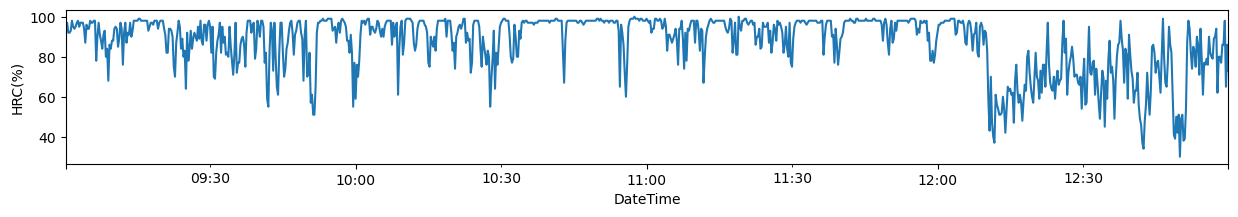

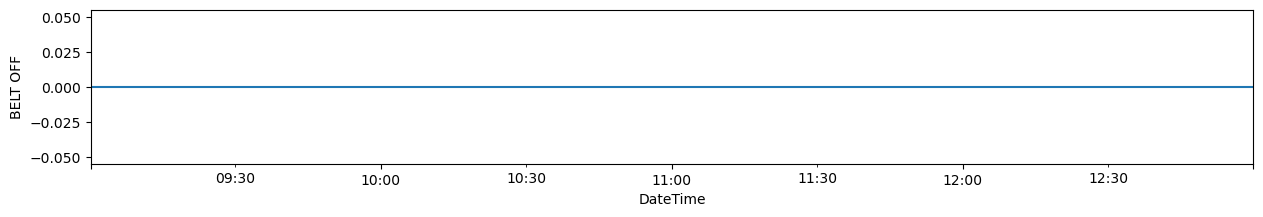

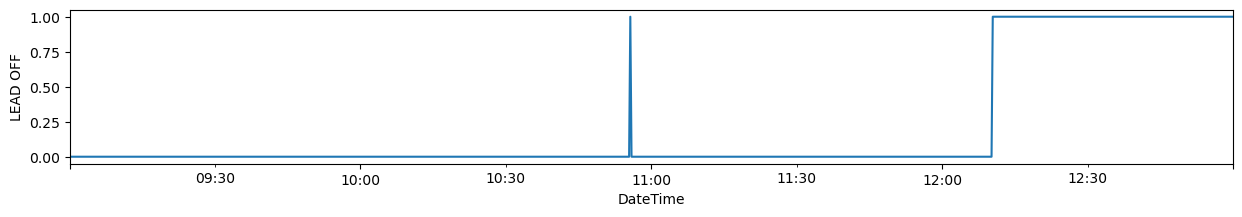

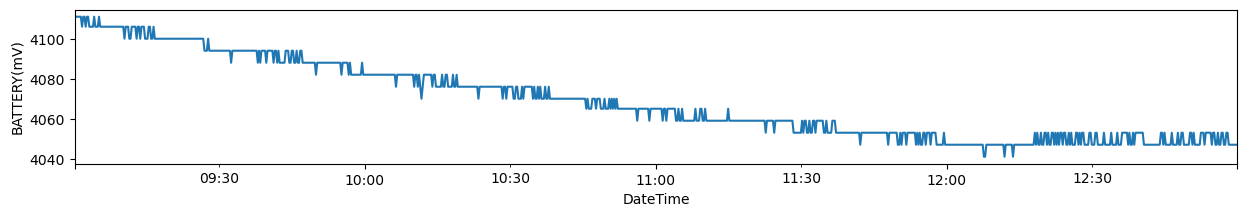

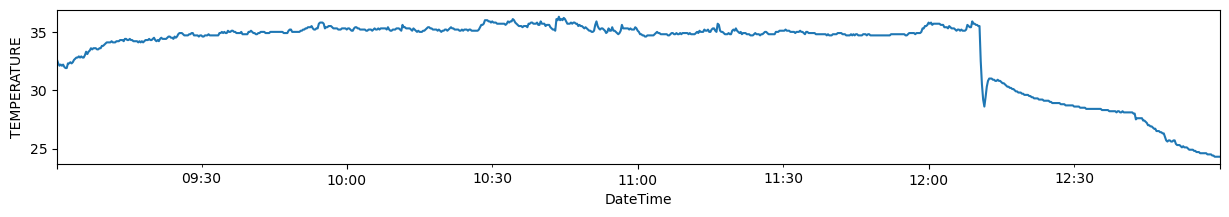

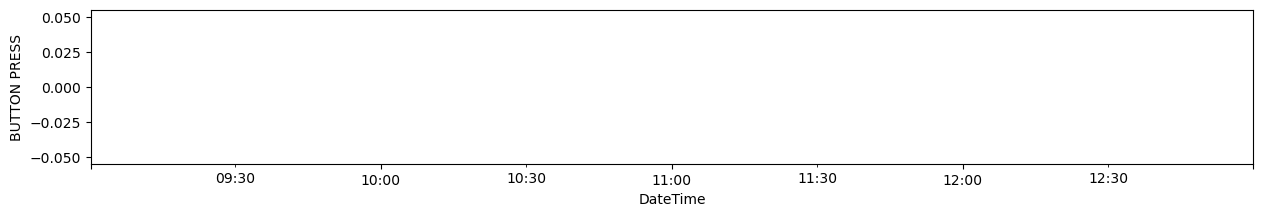

1.3831367492675781


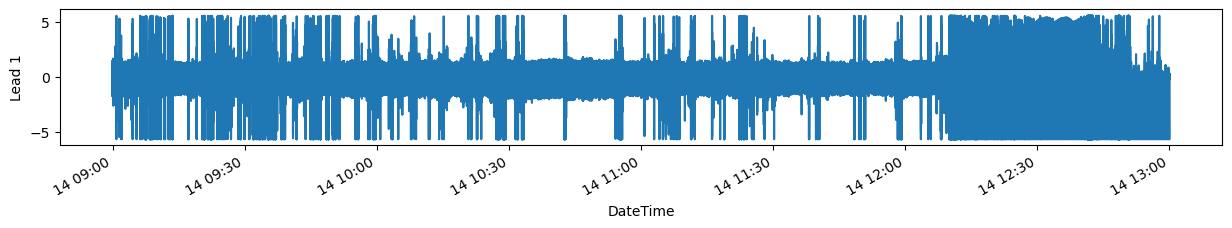

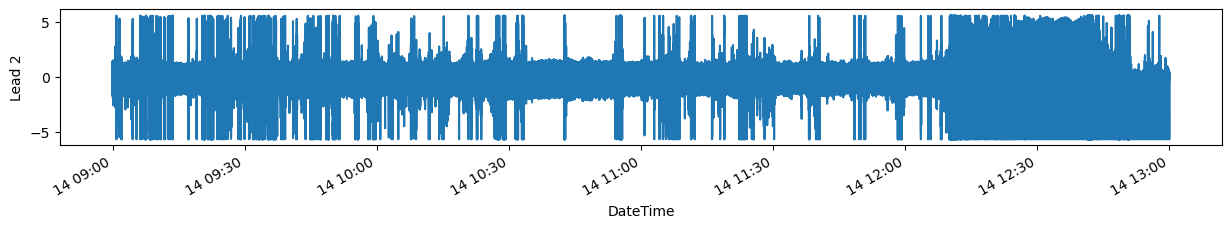

112.54880452156067


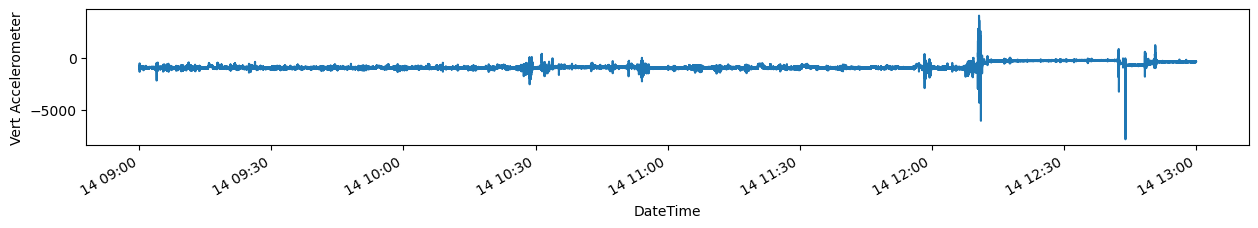

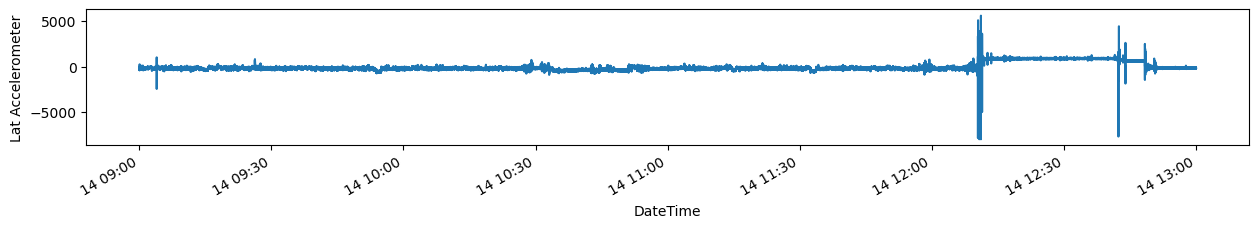

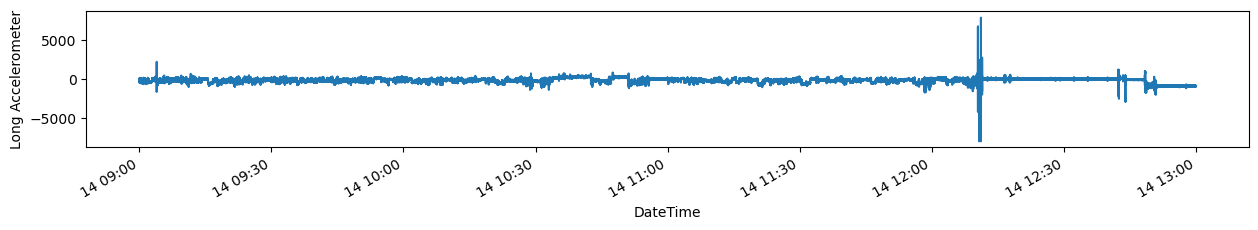

266.2131576538086


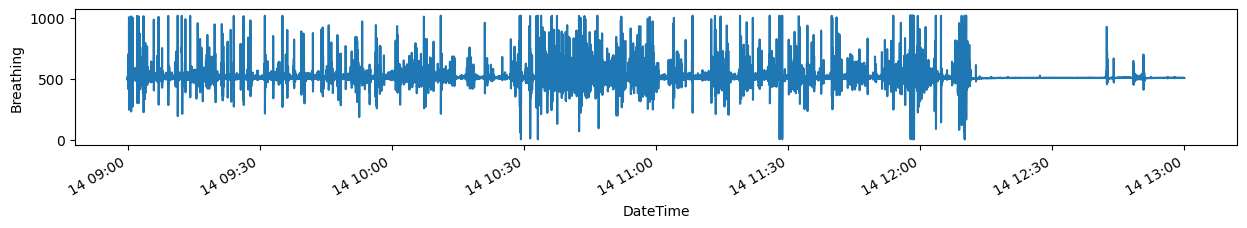

271.54227447509766


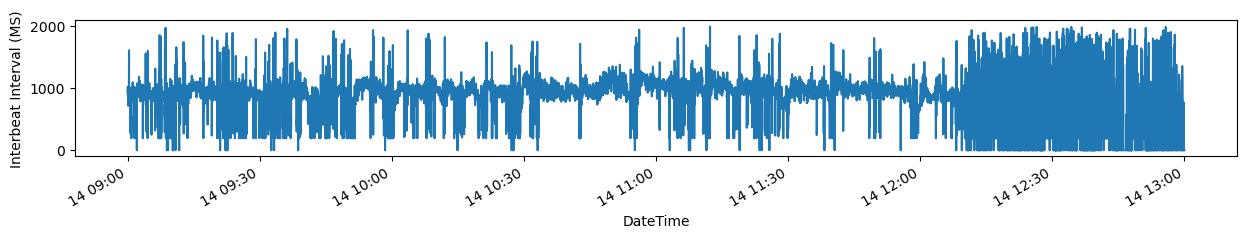

271.9325923919678


In [ ]:
tic = time.time()

for eq_file_loc in matched:
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
#     print(V.iloc[:2,:])
    qex.test_plot_signals_interval(V,t1,t2)
    print(time.time()-tic)

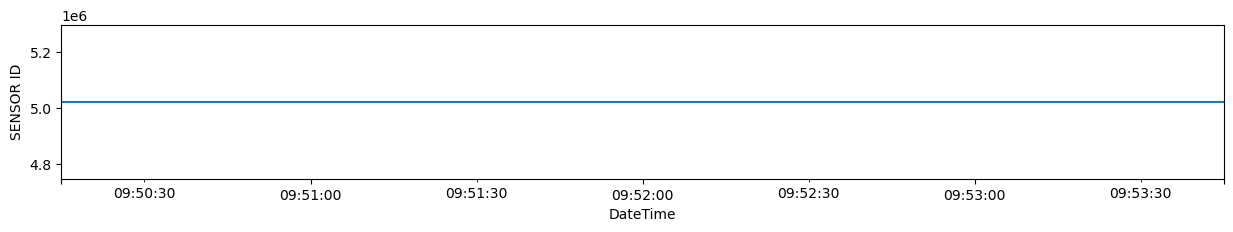

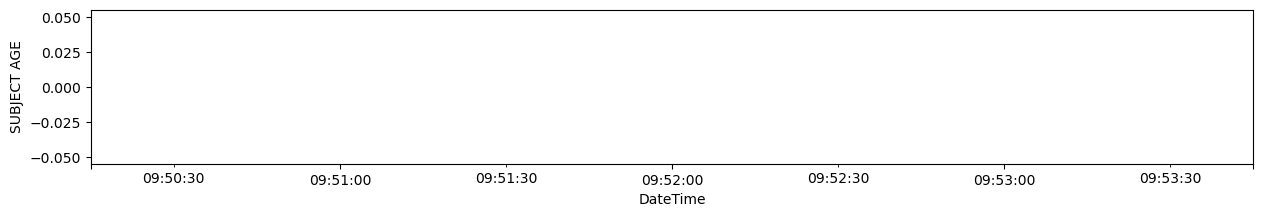

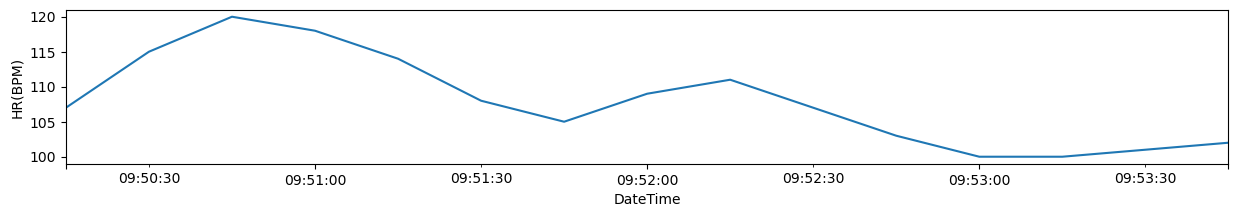

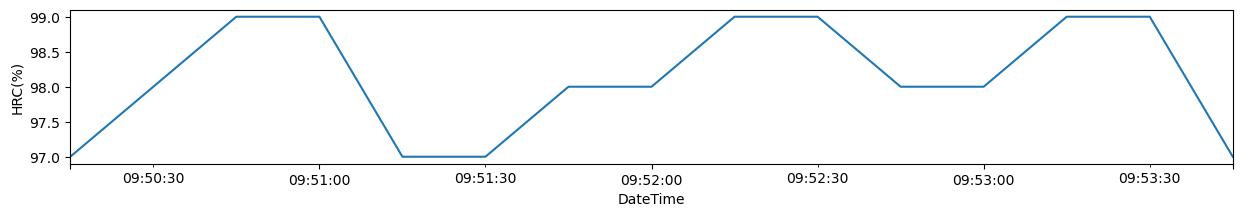

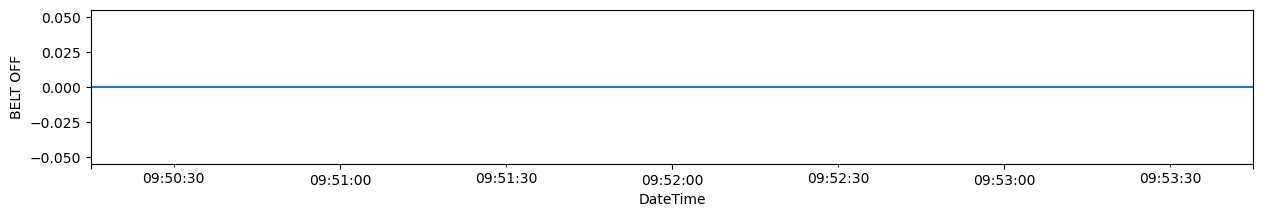

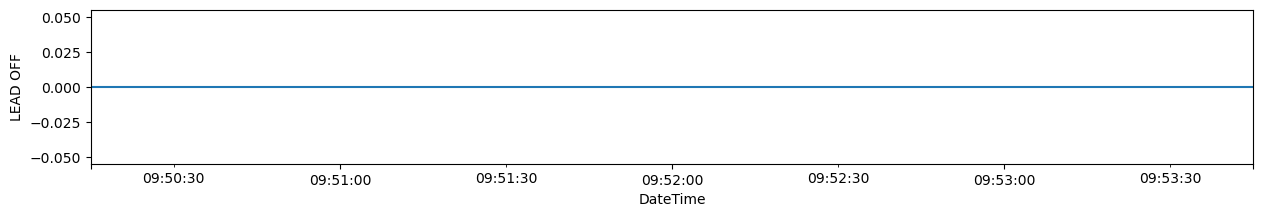

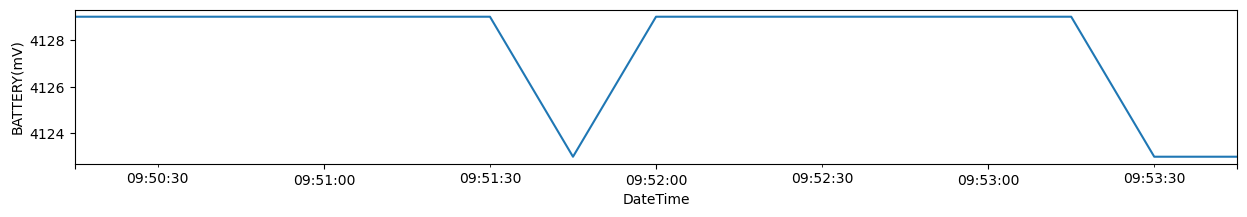

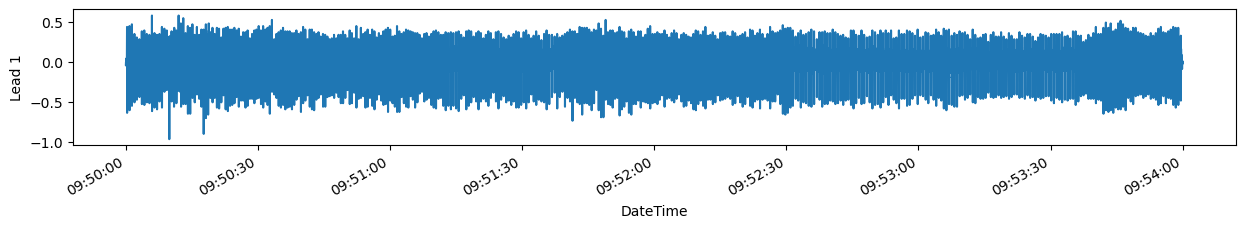

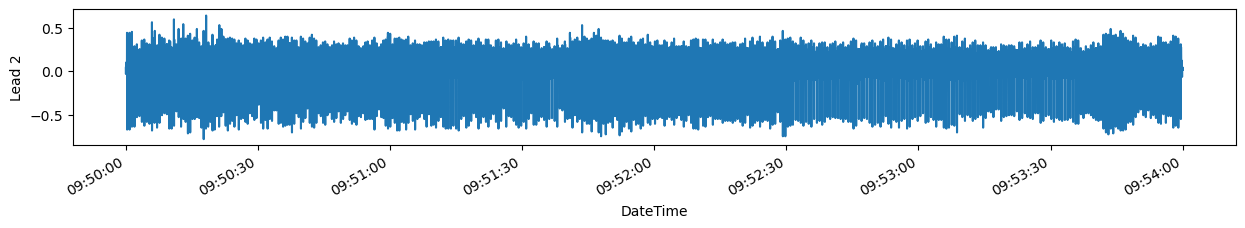

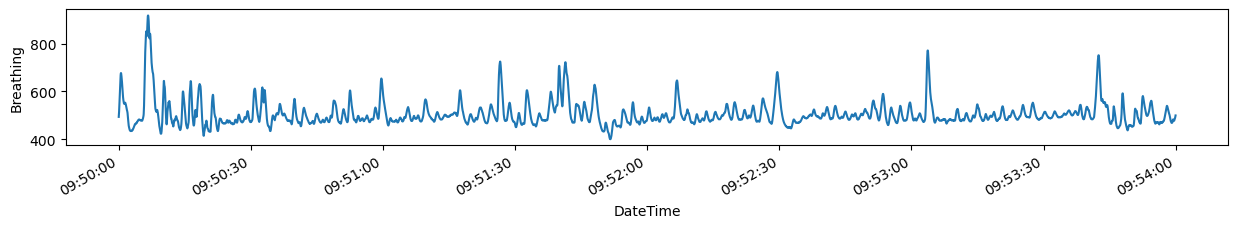

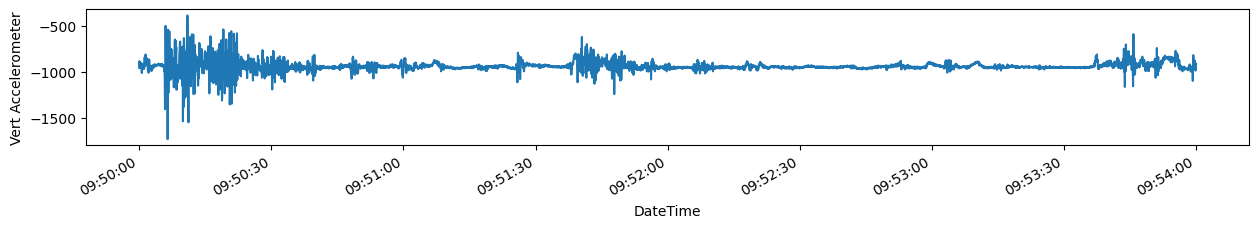

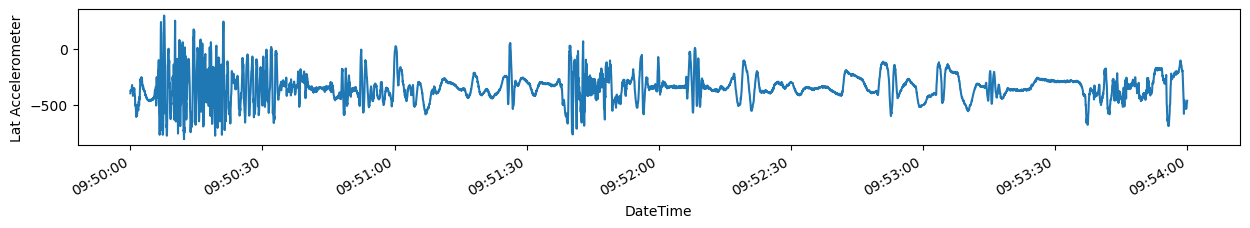

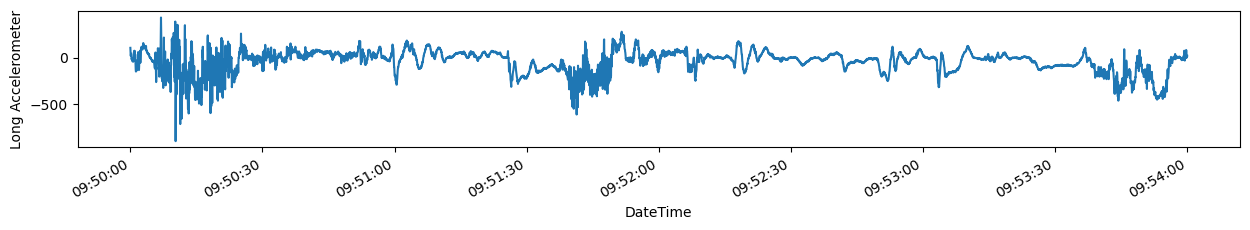

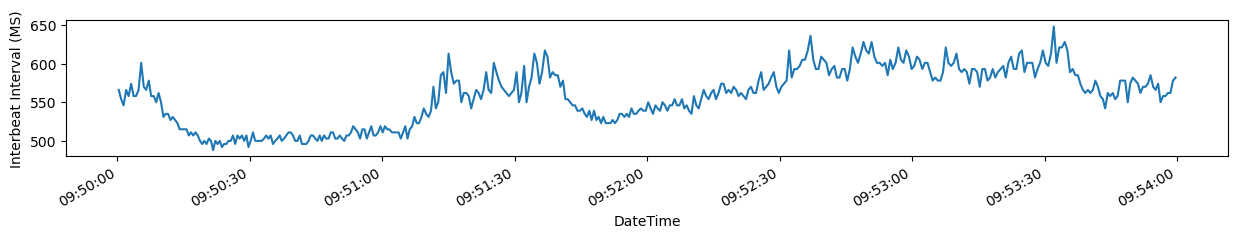

No data


In [104]:
# to save exported plots
plotname = 'ViolinPlayingPilot'
for eq_file_loc in matched:
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
#     print(V.iloc[:2,:])
    qex.test_plot_signals_interval_save(V,t1,t2,plotname)

In [45]:
eq_file_loc

'C:\\Users\\fourMs lab\\Documents\\Equivital\\ProjectData\\SoloRecordings\\SEM\\Pilot_1\\23020100_1.SEM'